In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 1T\[MT10] Series de Tiempo\Clases prácticas\Práctica 1-20250419\uncovered.xlsx"
df = pd.read_excel(path)
df.head()

,dateid01,dateid,dep,dif,e,libor,tbill
0,1978-07-01,1978-09-30 23:59:59.999,NaN,-0.53,1.8497,6.82,6.29
1,1978-10-01,1978-12-31 23:59:59.999,0.024436,-2.01,1.8949,9.02,7.01
2,1979-01-01,1979-03-31 23:59:59.999,0.059423,-1.67,2.0075,9.66,7.99
3,1979-04-01,1979-06-30 23:59:59.999,-0.001096,-2.28,2.0053,11.63,9.35
4,1979-07-01,1979-09-30 23:59:59.999,0.034010,-3.20,2.0735,12.66,9.46


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dateid01  121 non-null    datetime64[ns]
 1   dateid    121 non-null    datetime64[ns]
 2   dep       120 non-null    float64       
 3   dif       121 non-null    float64       
 4   e         121 non-null    float64       
 5   libor     121 non-null    float64       
 6   tbill     121 non-null    float64       
dtypes: datetime64[ns](2), float64(5)
memory usage: 6.7 KB


In [20]:
df['dateid01'] = pd.to_datetime(df['dateid01'])
df['dateidQ'] = df['dateid01'].dt.to_period('Q')
df.sort_values(by=['dateid01'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dateid01  121 non-null    datetime64[ns]
 1   dateid    121 non-null    datetime64[ns]
 2   dep       120 non-null    float64       
 3   dif       121 non-null    float64       
 4   e         121 non-null    float64       
 5   libor     121 non-null    float64       
 6   tbill     121 non-null    float64       
 7   dateidQ   121 non-null    period[Q-DEC] 
dtypes: datetime64[ns](2), float64(5), period[Q-DEC](1)
memory usage: 7.7 KB


In [15]:
df_f = df[['dateid', 'dep', 'dif']].dropna()
df_f.set_index('dateid', inplace=True)

from statsmodels.tsa.api import VAR

# Crear el modelo VAR.
model = VAR(df_f, freq='QE')
var_results = model.fit(maxlags=2)
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 02, May, 2025
Time:                     18:22:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.58929
Nobs:                     118.000    HQIC:                  -5.72876
Log likelihood:           18.7523    FPE:                 0.00295577
AIC:                     -5.82410    Det(Omega_mle):      0.00272035
--------------------------------------------------------------------
Results for equation dep
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.003884         0.007354           -0.528           0.597
L1.dep         0.115925         0.098136            1.181           0.237
L1.dif        -0.004421         0.004114           -1.075           0.282
L2.dep        -0

In [5]:
import statsmodels.api as sm

# Supongamos que df tiene las tres columnas: y1, y2, y3
# Y queremos un VAR con p rezagos
p = 2  # número de rezagos

# Crear las variables rezagadas
df_lagged = pd.concat([df_f.shift(i) for i in range(1, p+1)], axis=1)
df_lagged.columns = [f'{col}_lag{i}' for i in range(1, p+1) for col in df_f.columns]

# DataFrame final: quitamos los primeros p registros (por el rezago)
df_model = pd.concat([df_f, df_lagged], axis=1).dropna()

# Variables endógenas (Y) y variables explicativas (X)
Y = df_model[df_f.columns]
X = df_model.drop(columns=df_f.columns)
X = sm.add_constant(X)  # agregar intercepto

results = {}

for col in Y.columns:
    model = sm.OLS(Y[col], X).fit()
    n = model.nobs  # número de observaciones
    k = model.df_model + 1  # número de parámetros (incluyendo intercepto)

    aic_manual = (2 * k - 2 * model.llf) / n
    bic_manual = (np.log(n) * k - 2 * model.llf) / n

    results[col] = {
        'R2': model.rsquared,
        'Adj_R2': model.rsquared_adj,
        'Sum_sq_resids': np.sum(model.resid ** 2),
        'SE_equation': np.sqrt(np.sum(model.resid ** 2) / model.df_resid),
        'F-statistic': model.fvalue,
        'LogLikelihood': model.llf,
        'AIC': aic_manual,
        'BIC': bic_manual,
        'Mean_dependent': np.mean(Y[col]),
        'SD_dependent': np.std(Y[col], ddof=1)
    }

pd.DataFrame(results)

,dep,dif
R2,0.036608,0.749754
Adj_R2,0.002505,0.740896
Sum_sq_resids,0.260980,147.559395
SE_equation,0.048058,1.142732
F-statistic,1.073467,84.638900
LogLikelihood,193.290967,-180.623970
AIC,-3.191372,3.146169
BIC,-3.073970,3.263571
Mean_dependent,0.001048,-2.814153
SD_dependent,0.048118,2.244951


In [12]:
def eviews_style_stats(var_result):
    """
    Emula exactamente la salida de EViews para un VAR de statsmodels.
    Calcula determinantes ajustados y no ajustados, log likelihood, AIC, BIC y número de coeficientes.
    """
    n_obs = var_result.nobs
    n_eqs = var_result.neqs
    p = var_result.k_ar

    # Número de parámetros estimados por ecuación
    k_per_eq = n_eqs * p + 1

    # Matriz de residuos
    resid = var_result.resid

    # Covarianza de residuos (ajustada y no ajustada)
    sigma_u_adj = (resid.T @ resid) / (n_obs - k_per_eq)
    sigma_u_unadj = (resid.T @ resid) / n_obs

    # Determinantes
    det_sigma_u_adj = np.linalg.det(sigma_u_adj)
    det_sigma_u = np.linalg.det(sigma_u_unadj)

    # Log-likelihood
    loglik = var_result.llf

    # Número total de parámetros
    k_total = n_eqs * (n_eqs * p + 1)

    # AIC y BIC
    aic_var = (2 * k_total - 2 * loglik) / n_obs
    bic_var = (np.log(n_obs) * k_total - 2 * loglik) / n_obs

    # Mostrar resultados
    print(f"{'Determinant resid covariance (dof adj.)':40s} {det_sigma_u_adj:.6f}")
    print(f"{'Determinant resid covariance':40s} {det_sigma_u:.6f}")
    print(f"{'Log likelihood':40s} {loglik:.4f}")
    print(f"{'Akaike information criterion':40s} {aic_var:.6f}")
    print(f"{'Schwarz criterion':40s} {bic_var:.6f}")
    print(f"{'Number of coefficients':40s} {k_total}")

eviews_style_stats(var_results)

Determinant resid covariance (dof adj.)  0.002720
Determinant resid covariance             0.002495
Log likelihood                           18.7523
Akaike information criterion             -0.148344
Schwarz criterion                        0.086460
Number of coefficients                   10


In [13]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from scipy.stats import chi2

def select_var_eviews_exact(data, maxlags=8, trend='c'):
    """
    Reproduce la tabla VAR de EViews con:
      • criterios ajustados (AIC, SC, HQ, FPE) marcando el mínimo global
      • LR* secuencial modificado marcando el primer rechazo H₀ (5%)
    """
    k      = data.shape[1]
    T_orig = data.shape[0]
    T_max  = T_orig - maxlags
    const  = k * (1 + np.log(2*np.pi))
    crit_lr = chi2.ppf(0.95, k**2)

    # 1) Estimaciones y captura de llf, fpe, aic0, bic0, hq0, SSR
    llf, fpe, aic0, bic0, hq0, SSR = {}, {}, {}, {}, {}, {}
    for p in range(maxlags+1):
        data_p = data.iloc[maxlags-p:]
        res    = VAR(data_p, freq='QE').fit(p, trend=trend)
        llf[p]    = res.llf
        fpe[p]    = res.fpe
        aic0[p]   = res.aic
        bic0[p]   = res.bic
        hq0[p]    = res.hqic
        SSR[p]    = res.resid.T.dot(res.resid)

    # 2) Construcción de la tabla sin marcas
    rows = []
    for p in range(maxlags+1):
        # criterios ajustados
        AIC = aic0[p] + const
        SC  = bic0[p] + const
        HQ  = hq0[p]  + const

        # LR* secuencial modificado
        if p == 0:
            LR = np.nan
        else:
            _, ld0 = np.linalg.slogdet(SSR[p-1] / T_max)
            _, ld1 = np.linalg.slogdet(SSR[p]   / T_max)
            m       = 1 + k*p
            LR      = (T_max - m) * (ld0 - ld1)

        rows.append({
            'Lag':  p,
            'Nobs': T_max,
            'LogL': llf[p],
            'LR':   LR,
            'FPE':  fpe[p],
            'AIC':  AIC,
            'SC':   SC,
            'HQ':   HQ
        })

    df = pd.DataFrame(rows)

    # 0) Convertimos a object las columnas que vamos a stringificar
    for col in ['LR','FPE','AIC','SC','HQ']:
        df[col] = df[col].astype(object)

    # 3) Marcar mínimos globales para FPE, AIC, SC, HQ
    for crit in ['FPE','AIC','SC','HQ']:
        idx = df[crit].idxmin()
        df.loc[idx, crit] = f"{df.loc[idx,crit]:.6f}*"

    # 4) Marcar primer rechazo H₀ en LR* (descendiendo desde p=maxlags)
    #    según chi2(0.95, k^2)
    for p in range(maxlags, 0, -1):
        val = df.loc[df['Lag']==p, 'LR']
        # si aún es numérico y supera el crítico, marcamos y rompemos
        if isinstance(val.values[0], float) and val.values[0] > crit_lr:
            df.loc[df['Lag']==p, 'LR'] = f"{val.values[0]:.6f}*"
            break

    # 5) Formatear las columnas numéricas a 6 decimales
    for col in ['LogL','LR','FPE','AIC','SC','HQ']:
        df[col] = df[col].apply(lambda x: f"{x:.6f}" if isinstance(x, float) else x)

    return df[['Lag','Nobs','LogL','LR','FPE','AIC','SC','HQ']]

# Ejemplo de uso:
tabla = select_var_eviews_exact(df_f, maxlags=8, trend='c')
print(tabla.to_string(index=False))

 Lag  Nobs       LogL          LR       FPE        AIC         SC         HQ
   0   112 -65.909913         nan  0.011527   1.212677   1.261222   1.232373
   1   112  15.511113 158.480211* 0.002893* -0.169841* -0.024207* -0.110753*
   2   112  17.543977    3.884223  0.002996  -0.134714   0.108009  -0.036233
   3   112  19.063104    2.848362  0.003133  -0.090413   0.249400   0.047460
   4   112  19.656633    1.091669  0.003330  -0.029583   0.407319   0.147682
   5   112  21.960877    4.155869  0.003435   0.000699   0.534689   0.217356
   6   112  22.705315    1.316060  0.003643   0.058834   0.689914   0.314883
   7   112  27.354262    8.052641  0.003606   0.047245   0.775415   0.342687
   8   112  30.705579    5.685269  0.003653   0.058829   0.884088   0.393663


In [14]:
# Crear el modelo VAR.
model = VAR(df_f, freq='QE')
var_results1 = model.fit(maxlags=1)
print(var_results1.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 02, May, 2025
Time:                     00:26:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.72037
Nobs:                     119.000    HQIC:                  -5.80360
Log likelihood:           16.9922    FPE:                 0.00284989
AIC:                     -5.86050    Det(Omega_mle):      0.00271145
--------------------------------------------------------------------
Results for equation dep
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.003711         0.007145           -0.519           0.603
L1.dep         0.129073         0.094315            1.369           0.171
L1.dif        -0.001806         0.002037           -0.887           0.375

Results for equ

In [35]:
df_f = df[['dateid', 'dep', 'dif']].dropna()
df_f.set_index('dateid', inplace=True)

In [26]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from datetime import datetime

# 1. Cargar tus datos
# df = pd.read_csv('tus_datos.csv', parse_dates=['Date'], index_col='Date')
# Asegúrate de que tu índice sea trimestral y que existan las columnas 'DIF' y 'DEP'.

# 2. Crear variables rezagadas
df_f['DIF_lag1'] = df_f['dif'].shift(1)
df_f['DEP_lag1'] = df_f['dep'].shift(1)

# 3. Recortar el sample al periodo requerido y eliminar NaNs
# df_sys = df.loc['1979-03-31':'2008-09-30', ['DIF', 'DEP', 'DIF_lag1', 'DEP_lag1']].dropna()
df_f = df_f.dropna()
print(f"Observaciones incluidas (deberían ser 119): {len(df_f)}")
n_obs = len(df_f)

# 4. Estimar cada ecuación con OLS
do = sm.add_constant(df_f[['DIF_lag1','DEP_lag1']])
dif_model = sm.OLS(df_f['dif'], do).fit()
dep_model = sm.OLS(df_f['dep'], do).fit()

# 5. Matriz de covarianza de residuos y su determinante
res = np.column_stack((dif_model.resid, dep_model.resid))
cov_resid = np.cov(res, rowvar=False, bias=True)
det_cov = np.linalg.det(cov_resid)

# 6. Imprimir salida al estilo EViews
now = datetime.now()
date_str = now.strftime('%d/%m/%y')
time_str = now.strftime('%H:%M')
sample_q = f"{df_f.index.to_period('Q').min()} {df_f.index.to_period('Q').max()}"

tab = '    '
print(f"System: UNTITLED")
print(f"Estimation Method: Least Squares")
print(f"Date: {date_str}   Time: {time_str}")
print(f"Sample: {sample_q}")
print(f"Included observations: {n_obs}")
print(f"Total system (balanced) observations {n_obs*2}\n")

# Cabecera de coeficientes
def fmt(val, digits): return f"{val:.{digits}f}"
print(f"{tab}Coefficient{tab}Std. Error{tab}t-Statistic{tab}Prob.")
params = [
    ('C(1)', dif_model.params['DIF_lag1'], dif_model.bse['DIF_lag1'], dif_model.tvalues['DIF_lag1'], dif_model.pvalues['DIF_lag1']),
    ('C(2)', dif_model.params['DEP_lag1'], dif_model.bse['DEP_lag1'], dif_model.tvalues['DEP_lag1'], dif_model.pvalues['DEP_lag1']),
    ('C(3)', dif_model.params['const'],    dif_model.bse['const'],    dif_model.tvalues['const'],    dif_model.pvalues['const']),
    ('C(4)', dep_model.params['DIF_lag1'], dep_model.bse['DIF_lag1'], dep_model.tvalues['DIF_lag1'], dep_model.pvalues['DIF_lag1']),
    ('C(5)', dep_model.params['DEP_lag1'], dep_model.bse['DEP_lag1'], dep_model.tvalues['DEP_lag1'], dep_model.pvalues['DEP_lag1']),
    ('C(6)', dep_model.params['const'],    dep_model.bse['const'],    dep_model.tvalues['const'],    dep_model.pvalues['const']),
]
for name, coef, se, t, p in params:
    print(f"{name}\t{fmt(coef,6)}\t{fmt(se,6)}\t{fmt(t,5)}\t{fmt(p,4)}")

print(f"\nDeterminant residual covariance{tab*2}{det_cov:.6f}\n")

# 7. Resúmenes por ecuación
for model, eq in [(dif_model,'dif'), (dep_model,'dep')]:
    mean_dep = df_f[eq].mean()
    sd_dep   = df_f[eq].std(ddof=1)
    ssr      = np.sum(model.resid**2)
    rmse     = np.sqrt(model.mse_resid)
    dw_stat  = sm.stats.stattools.durbin_watson(model.resid)
    print(f"Equation: {eq} = {' + '.join(['C(1)' if eq=='DIF' else 'C(4)'] + ['*'.join(['DIF(-1)' if eq=='DIF' else 'DIF(-1)'])] )}")
    # Nota: ajusta el texto de la ecuación manualmente si prefieres exactitud
    if eq == 'DIF':
        print("Equation: DIF = C(1)*DIF(-1) + C(2)*DEP(-1) + C(3)")
    else:
        print("Equation: DEP = C(4)*DIF(-1) + C(5)*DEP(-1) + C(6)")
    print(f"Observations: {n_obs}")
    print(f"R-squared\t{model.rsquared:.6f}\tMean dependent var\t{mean_dep:.6f}")
    print(f"Adjusted R-squared\t{model.rsquared_adj:.6f}\tS.D. dependent var\t{sd_dep:.6f}")
    print(f"S.E. of regression\t{rmse:.6f}\tSum squared resid\t{ssr:.4f}")
    print(f"Durbin-Watson stat\t{dw_stat:.6f}\n")

Observaciones incluidas (deberían ser 119): 119
System: UNTITLED
Estimation Method: Least Squares
Date: 02/05/25   Time: 18:23
Sample: 1979Q1 2008Q3
Included observations: 119
Total system (balanced) observations 238

    Coefficient    Std. Error    t-Statistic    Prob.
C(1)	0.878092	0.048688	18.03497	0.0000
C(2)	3.345718	2.254235	1.48419	0.1405
C(3)	-0.365129	0.170765	-2.13819	0.0346
C(4)	-0.001806	0.002037	-0.88681	0.3770
C(5)	0.129073	0.094315	1.36853	0.1738
C(6)	-0.003711	0.007145	-0.51938	0.6045

Determinant residual covariance        0.002576

Equation: dif = C(4) + DIF(-1)
Equation: DEP = C(4)*DIF(-1) + C(5)*DEP(-1) + C(6)
Observations: 119
R-squared	0.742560	Mean dependent var	-2.804538
Adjusted R-squared	0.738121	S.D. dependent var	2.237878
S.E. of regression	1.145214	Sum squared resid	152.1358
Durbin-Watson stat	1.716658

Equation: dep = C(4) + DIF(-1)
Equation: DEP = C(4)*DIF(-1) + C(5)*DEP(-1) + C(6)
Observations: 119
R-squared	0.029029	Mean dependent var	0.001538
Adjusted

In [27]:
# Las restricciones tienen que ser lineales. Si no son lineales, EViews hace método Delta u otro método para linealizar. 

In [36]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from datetime import datetime
from scipy.stats import chi2
from scipy.linalg import block_diag

# 1. Cargar tus datos
# df = pd.read_csv('tus_datos.csv', parse_dates=['Date'], index_col='Date')
# Asegúrate de que tu índice sea trimestral y que existan las columnas 'DIF' y 'DEP'.

# 2. Crear variables rezagadas
df_f['DIF_lag1'] = df_f['dif'].shift(1)
df_f['DEP_lag1'] = df_f['dep'].shift(1)

# 3. Recortar el sample al periodo requerido y eliminar NaNs
# df_sys = df.loc['1979-03-31':'2008-09-30', ['DIF', 'DEP', 'DIF_lag1', 'DEP_lag1']].dropna()
df_f = df_f.dropna()
print(f"Observaciones incluidas (deberían ser 119): {len(df_f)}")
n_obs = len(df_f)

# 3. Estimar cada ecuación con OLS
do = sm.add_constant(df_f[['DIF_lag1','DEP_lag1']])
dif_model = sm.OLS(df_f['dif'], do).fit()
dep_model = sm.OLS(df_f['dep'], do).fit()

# 4. Matriz de covarianza de residuos y su determinante
res = np.column_stack((dif_model.resid, dep_model.resid))
cov_resid = np.cov(res, rowvar=False, bias=True)
det_cov = np.linalg.det(cov_resid)

# 5. Imprimir salida al estilo EViews
now = datetime.now()
date_str = now.strftime('%d/%m/%y')
time_str = now.strftime('%H:%M')
sample_q = f"{df_f.index.to_period('Q').min()} {df_f.index.to_period('Q').max()}"

tab = '    '
print(f"System: UNTITLED")
print(f"Estimation Method: Least Squares")
print(f"Date: {date_str}   Time: {time_str}")
print(f"Sample: {sample_q}")
print(f"Included observations: {n_obs}")
print(f"Total system (balanced) observations {n_obs*2}\n")

def fmt(val, digits): return f"{val:.{digits}f}"
coef_list = [
    ('C(1)', dif_model.params['DIF_lag1'], dif_model.bse['DIF_lag1'], dif_model.tvalues['DIF_lag1'], dif_model.pvalues['DIF_lag1']),
    ('C(2)', dif_model.params['DEP_lag1'], dif_model.bse['DEP_lag1'], dif_model.tvalues['DEP_lag1'], dif_model.pvalues['DEP_lag1']),
    ('C(3)', dif_model.params['const'],    dif_model.bse['const'],    dif_model.tvalues['const'],    dif_model.pvalues['const']),
    ('C(4)', dep_model.params['DIF_lag1'], dep_model.bse['DIF_lag1'], dep_model.tvalues['DIF_lag1'], dep_model.pvalues['DIF_lag1']),
    ('C(5)', dep_model.params['DEP_lag1'], dep_model.bse['DEP_lag1'], dep_model.tvalues['DEP_lag1'], dep_model.pvalues['DEP_lag1']),
    ('C(6)', dep_model.params['const'],    dep_model.bse['const'],    dep_model.tvalues['const'],    dep_model.pvalues['const']),
]
print(f"{tab}Coefficient{tab}Std. Error{tab}t-Statistic{tab}Prob.")
for name, coef, se, t, p in coef_list:
    print(f"{name}\t{fmt(coef,6)}\t{fmt(se,6)}\t{fmt(t,5)}\t{fmt(p,4)}")

print(f"\nDeterminant residual covariance{tab*2}{det_cov:.6f}\n")

def print_eq_summary(model, eq, labels):
    mean_dep = df_f[eq].mean()
    sd_dep   = df_f[eq].std(ddof=1)
    ssr      = np.sum(model.resid**2)
    rmse     = np.sqrt(model.mse_resid)
    dw_stat  = sm.stats.stattools.durbin_watson(model.resid)
    print(f"Equation: {eq} = {labels[0]}*DIF(-1) + {labels[1]}*DEP(-1) + {labels[2]}")
    print(f"Observations: {n_obs}")
    print(f"R-squared\t{model.rsquared:.6f}\tMean dependent var\t{mean_dep:.6f}")
    print(f"Adjusted R-squared\t{model.rsquared_adj:.6f}\tS.D. dependent var\t{sd_dep:.6f}")
    print(f"S.E. of regression\t{rmse:.6f}\tSum squared resid\t{ssr:.4f}")
    print(f"Durbin-Watson stat\t{dw_stat:.6f}\n")

print_eq_summary(dif_model, 'dif', ['C(1)', 'C(2)', 'C(3)'])
print_eq_summary(dep_model, 'dep', ['C(4)', 'C(5)', 'C(6)'])

# 6. Wald Coefficient Test usando el método delta
# Theta ordenado para block_diag: [C3, C1, C2, C6, C4, C5]
theta = np.array([
    dif_model.params['const'],    # C3
    dif_model.params['DIF_lag1'], # C1
    dif_model.params['DEP_lag1'], # C2
    dep_model.params['const'],    # C6
    dep_model.params['DIF_lag1'], # C4
    dep_model.params['DEP_lag1']  # C5
])
# Covarianza de parámetros en mismo orden
cov_theta = block_diag(dif_model.cov_params().loc[['const','DIF_lag1','DEP_lag1'], ['const','DIF_lag1','DEP_lag1']],
                       dep_model.cov_params().loc[['const','DIF_lag1','DEP_lag1'], ['const','DIF_lag1','DEP_lag1']])

# Restricciones y Jacobiano según theta ordenado
C3,C1,C2,C6,C4,C5 = theta
r = np.array([
    C3 - C6 - C4*C3 - C5*C6,
    C1 - C4*C1 - C5*C4,
    C2 - C4*C2 - C5*C5
])
J = np.array([
    [1 - C4,      0,      0, -1 - C5, -C3,    -C6],
    [0,      1 - C4,      0,      0, -C1 - C5, -C4],
    [0,           0, 1 - C4,      0,    -C2, -2*C5]
])
# Varianza de restricciones
var_r = J @ cov_theta @ J.T
# Estadístico de Wald
W = float(r.T @ np.linalg.inv(var_r) @ r)
df_w = len(r)
p_value = 1 - chi2.cdf(W, df_w)

print("Wald Test:")
print("System: UNTITLED\n")
print("Test Statistic\tValue\tdf\tProbability")
print(f"Chi-square\t{W:.3f}\t{df_w}\t{p_value:.4f}\n")
print("Null Hypothesis: C(3)=C(6)+C(4)*C(3)+C(5)*C(6),C(1)=C(4)*C(1)+C(5)*C(4),C(2)=C(4)*C(2)+C(5)*C(5)\n")
print("Null Hypothesis Summary:\n")
print("Normalized Restriction (= 0)\tValue\tStd. Err.\n")
names = [
    "C(3) - C(3)*C(4) - C(6) - C(5)*C(6)",
    "C(1) - C(1)*C(4) - C(4)*C(5)",
    "C(2) - C(2)*C(4) - C(5)^2"
]
for i, name in enumerate(names):
    se_r = np.sqrt(var_r[i,i])
    print(f"{name}\t{r[i]:.6f}\t{se_r:.6f}")
print("\nDelta method computed using analytic derivatives.")

Observaciones incluidas (deberían ser 119): 119
System: UNTITLED
Estimation Method: Least Squares
Date: 02/05/25   Time: 18:39
Sample: 1979Q1 2008Q3
Included observations: 119
Total system (balanced) observations 238

    Coefficient    Std. Error    t-Statistic    Prob.
C(1)	0.878092	0.048688	18.03497	0.0000
C(2)	3.345718	2.254235	1.48419	0.1405
C(3)	-0.365129	0.170765	-2.13819	0.0346
C(4)	-0.001806	0.002037	-0.88681	0.3770
C(5)	0.129073	0.094315	1.36853	0.1738
C(6)	-0.003711	0.007145	-0.51938	0.6045

Determinant residual covariance        0.002576

Equation: dif = C(1)*DIF(-1) + C(2)*DEP(-1) + C(3)
Observations: 119
R-squared	0.742560	Mean dependent var	-2.804538
Adjusted R-squared	0.738121	S.D. dependent var	2.237878
S.E. of regression	1.145214	Sum squared resid	152.1358
Durbin-Watson stat	1.716658

Equation: dep = C(4)*DIF(-1) + C(5)*DEP(-1) + C(6)
Observations: 119
R-squared	0.029029	Mean dependent var	0.001538
Adjusted R-squared	0.012289	S.D. dependent var	0.048212
S.E. of regres

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from datetime import datetime
from scipy.stats import chi2
from scipy.linalg import block_diag


def estimate_var_system(
    df: pd.DataFrame,
    varnames: list,
    lags: int = 1,
    start: str = None,
    end: str = None,
    system_name: str = 'UNTITLED'
):
    """
    Estima un VAR(p) estilo sistema OLS y realiza el Wald test (solo p=1).

    Parámetros:
    - df: DataFrame con las series.
    - varnames: lista de nombres de columnas endógenas (ej. ['DIF','DEP']).
    - lags: número de rezagos p.
    - start, end: fechas de inicio y fin para la muestra (formato 'YYYY-MM-DD').
    - system_name: nombre del sistema para impresión.

    Retorna:
    - models: dict de resultados OLS para cada ecuación.
    - det_cov: determinante de la covarianza de residuos.
    - wtest: tupla (W, df_w, p_value) con estadístico Wald (solo p=1).
    """
    # 1. Generar rezagos dinámicos
    df_work = df.copy()
    lag_cols = []
    for lag in range(1, lags+1):
        for v in varnames:
            col = f"{v}_lag{lag}"
            df_work[col] = df_work[v].shift(lag)
            lag_cols.append(col)

    # 2. Seleccionar muestra
    df_sys = df_work.loc[start:end] if start and end else df_work
    df_sys = df_sys.dropna()
    n_obs = len(df_sys)
    n_eq = len(varnames)

    # 3. Preparar regresores
    X = sm.add_constant(df_sys[lag_cols])

    # 4. Estimar ecuaciones
    models = {v: sm.OLS(df_sys[v], X).fit() for v in varnames}

    # 5. Covarianza de residuos
    res = np.column_stack([models[v].resid for v in varnames])
    cov_resid = np.cov(res, rowvar=False, bias=True)
    det_cov = np.linalg.det(cov_resid)

    # 6. Imprimir encabezado
    now = datetime.now()
    date_str = now.strftime('%d/%m/%y')
    time_str = now.strftime('%H:%M')
    sample_q = f"{df_sys.index.to_period('Q').min()} {df_sys.index.to_period('Q').max()}"
    sep = '    '

    print(f"System: {system_name}")
    print(f"Estimation Method: Least Squares")
    print(f"Date: {date_str}   Time: {time_str}")
    print(f"Sample: {sample_q}")
    print(f"Included observations: {n_obs}")
    print(f"Total system (balanced) observations {n_obs*n_eq}\n")

    # 7. Mostrar coeficientes
    print(f"Variable{sep}Coef.{sep}Std.Err.{sep}t-Stat{sep}P>|t|")
    for v in varnames:
        m = models[v]
        for lag in range(1, lags+1):
            name = f"{v}(-{lag})"
            coef = m.params[f"{v}_lag{lag}"]
            se = m.bse[f"{v}_lag{lag}"]
            tval = m.tvalues[f"{v}_lag{lag}"]
            pval = m.pvalues[f"{v}_lag{lag}"]
            print(f"{name}{sep}{coef:.6f}{sep}{se:.6f}{sep}{tval:.6f}{sep}{pval:.4f}")
        # constante
        coef = m.params['const']
        se = m.bse['const']
        tval = m.tvalues['const']
        pval = m.pvalues['const']
        print(f"const{sep}{coef:.6f}{sep}{se:.6f}{sep}{tval:.6f}{sep}{pval:.4f}\n")

    print(f"Determinant residual covariance{sep}{sep}{det_cov:.6f}\n")

    # 8. Resumen por ecuación
    for v in varnames:
        m = models[v]
        print(f"Equation: {v} = "+
              " + ".join([f"({i+1})*{v}(-{i+1})" for i in range(lags)]) +
              " + const")
        mean_dep = df_sys[v].mean()
        sd_dep = df_sys[v].std(ddof=1)
        ssr = np.sum(m.resid**2)
        rmse = np.sqrt(m.mse_resid)
        dw = sm.stats.stattools.durbin_watson(m.resid)
        print(f"Observations: {n_obs}")
        print(f"R-squared\t{m.rsquared:.6f}\tMean dep.var\t{mean_dep:.6f}")
        print(f"Adj.R-squared\t{m.rsquared_adj:.6f}\tSD dep.var\t{sd_dep:.6f}")
        print(f"S.E.regression\t{rmse:.6f}\tSum sq.resid\t{ssr:.4f}")
        print(f"Durbin-Watson stat\t{dw:.6f}\n")

    # 9. Wald test solo si p=1
    wtest = None
    if lags == 1 and n_eq == 2:
        # mismo esquema de restricciones
        theta = np.array([
            models[varnames[0]].params['const'],
            models[varnames[0]].params[f"{varnames[0]}_lag1"],
            models[varnames[0]].params[f"{varnames[1]}_lag1"],
            models[varnames[1]].params['const'],
            models[varnames[1]].params[f"{varnames[0]}_lag1"],
            models[varnames[1]].params[f"{varnames[1]}_lag1"]
        ])
        cov_theta = block_diag(
            models[varnames[0]].cov_params().loc[['const']+lag_cols, ['const']+lag_cols],
            models[varnames[1]].cov_params().loc[['const']+lag_cols, ['const']+lag_cols]
        )
        C3,C1,C2,C6,C4,C5 = theta
        r = np.array([C3 - C6 - C4*C3 - C5*C6,
                      C1 - C4*C1 - C5*C4,
                      C2 - C4*C2 - C5*C5])
        J = np.array([
            [1 - C4,0,0,-1 - C5,-C3,-C6],
            [0,1 - C4,0,0,-C1 - C5,-C4],
            [0,0,1 - C4,0,-C2,-2*C5]
        ])
        var_r = J @ cov_theta @ J.T
        W = float(r.T @ np.linalg.inv(var_r) @ r)
        df_w = len(r)
        pval = 1 - chi2.cdf(W, df_w)
        print("Wald Test:")
        print(f"Chi-square\t{W:.3f}\tdf={df_w}\tp={pval:.4f}\n")
        wtest = (W, df_w, pval)

    return models, det_cov, wtest

# Ejemplo:
# estimate_var_system(df, ['DIF','DEP'], lags=2, start='1979-03-31', end='2008-09-30')


In [1]:
# 46:40. ¿Qué hace el test?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 1T\[MT10] Series de Tiempo\Clases prácticas\Práctica 1-20250419\bc.xlsx"
df = pd.read_excel(path)
df.head()

,dateid01,dateid,dlgp,gdp,u
0,1948-04-01,1948-06-30 23:59:59.999,NaN,267.3,0.039000
1,1948-07-01,1948-09-30 23:59:59.999,0.024391,273.9,0.035667
2,1948-10-01,1948-12-31 23:59:59.999,0.004735,275.2,0.038000
3,1949-01-01,1949-03-31 23:59:59.999,-0.019076,270.0,0.040333
4,1949-04-01,1949-06-30 23:59:59.999,-0.014174,266.2,0.050000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dateid01  240 non-null    datetime64[ns]
 1   dateid    240 non-null    datetime64[ns]
 2   dlgp      239 non-null    float64       
 3   gdp       240 non-null    float64       
 4   u         240 non-null    float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 9.5 KB


In [2]:
df['dateid01'] = pd.to_datetime(df['dateid01'])
df['dateidQ'] = df['dateid01'].dt.to_period('Q')
df.sort_values(by=['dateid01'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dateid01  240 non-null    datetime64[ns]
 1   dateid    240 non-null    datetime64[ns]
 2   dlgp      239 non-null    float64       
 3   gdp       240 non-null    float64       
 4   u         240 non-null    float64       
 5   dateidQ   240 non-null    period[Q-DEC] 
dtypes: datetime64[ns](2), float64(3), period[Q-DEC](1)
memory usage: 11.4 KB


In [9]:
# Unit Root Test.
# H0: no es estacionario.
# Dickey-Fuller test no capta cambios estructurales de varianza.

In [3]:
df_f = df[['dateid01', 'dlgp', 'gdp', 'u']].dropna()

In [25]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 239 entries, 1948Q3 to 2008Q1
Freq: Q-DEC
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dlgp    239 non-null    float64
 1   gdp     239 non-null    float64
 2   u       239 non-null    float64
dtypes: float64(3)
memory usage: 7.5 KB


In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

# # 1a) Convierte tu columna de fecha
# df_f['dateid01'] = pd.to_datetime(df_f['dateid01'])

# # 1b) Ponla como índice
# df_f = df_f.set_index('dateid01')

# # 1c) Ahora conviertes a PeriodIndex trimestral
# df_f.index = df_f.index.to_period('Q')

dlgp_q = df['u']

# --- 3) ADF Test (constante, SIC=BIC, maxlag=14) ---
adf_res = adfuller(dlgp_q, maxlag=14, regression='c', autolag='BIC')
adf_stat, pvalue, used_lag, nobs, crit_vals, icbest = adf_res

print("Null Hypothesis: DLGP has a unit root")
print("Exogenous: Constant")
print(f"Lag Length: {used_lag} (automatic via SIC, maxlag=14)\n")
print("\t\t t-Statistic\tProb.*")
print(f"ADF test statistic\t {adf_stat:.6f}\t {pvalue:.4f}\n")

print("Test critical values (MacKinnon 1996):")
for lvl, val in crit_vals.items():
    print(f"  {lvl} level\t {val:.6f}")
print("\n*Los ligeros descuadres (~0.0003) frente a EViews son por diferencias de interpolación.\n")

# --- 4) Ecuación auxiliar ΔDLGP_t = α + β·DLGP_{t−1} + ∑γ_iΔDLGP_{t−i} + ε_t ---
df_aux = pd.DataFrame({
    'd_dlgp': dlgp_q.diff(),
    'dlgplag': dlgp_q.shift(1)
})
for i in range(1, used_lag+1):
    df_aux[f'd_dlgp_lag{i}'] = df_aux['d_dlgp'].shift(i)
df_aux = df_aux.dropna()

y = df_aux['d_dlgp']
cols = ['dlgplag'] + [f'd_dlgp_lag{i}' for i in range(1, used_lag+1)]
X = sm.add_constant(df_aux[cols])
model = sm.OLS(y, X).fit()

# --- 5) Tabla de coeficientes ---
print(model.summary().tables[1])

# --- 6) Métricas estilo EViews ---

# Durbin–Watson
dw_stat = durbin_watson(model.resid)

# HQIC (manual)
n = model.nobs
k = model.df_model + 1
hqic_val = -2*model.llf + 2*k*np.log(np.log(n))

# Información “por observación” (EViews):
aic_per_obs  = model.aic / n
bic_per_obs  = model.bic / n
hqic_per_obs = hqic_val   / n

print(f"\nR-squared:            {model.rsquared:.6f}    "
      f"Mean dependent var: {y.mean():.6f}")
print(f"Adj. R-squared:       {model.rsquared_adj:.6f}    "
      f"S.D. dependent var: {y.std():.6f}")
print(f"S.E. of regression:   {np.sqrt(model.mse_resid):.6f}    "
      f"Akaike info criterion: {aic_per_obs:.6f}")
print(f"Sum squared resid:    {model.ssr:.6f}    "
      f"Schwarz criterion:    {bic_per_obs:.6f}")
print(f"Log likelihood:       {model.llf:.4f}    "
      f"Hannan-Quinn criter.: {hqic_per_obs:.6f}")
print(f"F-statistic:          {model.fvalue:.6f}    "
      f"Prob(F-statistic):    {model.f_pvalue:.6f}")
print(f"Durbin-Watson stat:   {dw_stat:.6f}")

Null Hypothesis: DLGP has a unit root
Exogenous: Constant
Lag Length: 1 (automatic via SIC, maxlag=14)

		 t-Statistic	Prob.*
ADF test statistic	 -4.290701	 0.0005

Test critical values (MacKinnon 1996):
  1% level	 -3.458128
  5% level	 -2.873762
  10% level	 -2.573283

*Los ligeros descuadres (~0.0003) frente a EViews son por diferencias de interpolación.

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0032      0.001      4.192      0.000       0.002       0.005
dlgplag        -0.0571      0.013     -4.291      0.000      -0.083      -0.031
d_dlgp_lag1     0.6170      0.051     12.101      0.000       0.517       0.717

R-squared:            0.396538    Mean dependent var: 0.000055
Adj. R-squared:       0.391403    S.D. dependent var: 0.003901
S.E. of regression:   0.003043    Akaike info criterion: -8.739455
Sum squared resid:    0.002176    Schwarz cri

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

# 1a) Convierte tu columna de fecha
df_f['dateid01'] = pd.to_datetime(df_f['dateid01'])

# 1b) Ponla como índice
df_f = df_f.set_index('dateid01')

# 1c) Ahora conviertes a PeriodIndex trimestral
df_f.index = df_f.index.to_period('Q')

dlgp_q = df_f['dlgp']

# --- 3) ADF Test (constante, SIC=BIC, maxlag=14) ---
adf_res = adfuller(dlgp_q, maxlag=14, regression='c', autolag='BIC')
adf_stat, pvalue, used_lag, nobs, crit_vals, icbest = adf_res

print("Null Hypothesis: DLGP has a unit root")
print("Exogenous: Constant")
print(f"Lag Length: {used_lag} (automatic via SIC, maxlag=14)\n")
print("\t\t t-Statistic\tProb.*")
print(f"ADF test statistic\t {adf_stat:.6f}\t {pvalue:.4f}\n")

print("Test critical values (MacKinnon 1996):")
for lvl, val in crit_vals.items():
    print(f"  {lvl} level\t {val:.6f}")
print("\n*Los ligeros descuadres (~0.0003) frente a EViews son por diferencias de interpolación.\n")

# --- 4) Ecuación auxiliar ΔDLGP_t = α + β·DLGP_{t−1} + ∑γ_iΔDLGP_{t−i} + ε_t ---
df_aux = pd.DataFrame({
    'd_dlgp': dlgp_q.diff(),
    'dlgplag': dlgp_q.shift(1)
})
for i in range(1, used_lag+1):
    df_aux[f'd_dlgp_lag{i}'] = df_aux['d_dlgp'].shift(i)
df_aux = df_aux.dropna()

y = df_aux['d_dlgp']
cols = ['dlgplag'] + [f'd_dlgp_lag{i}' for i in range(1, used_lag+1)]
X = sm.add_constant(df_aux[cols])
model = sm.OLS(y, X).fit()

# --- 5) Tabla de coeficientes ---
print(model.summary().tables[1])

# --- 6) Métricas estilo EViews ---

# Durbin–Watson
dw_stat = durbin_watson(model.resid)

# HQIC (manual)
n = model.nobs
k = model.df_model + 1
hqic_val = -2*model.llf + 2*k*np.log(np.log(n))

# Información “por observación” (EViews):
aic_per_obs  = model.aic / n
bic_per_obs  = model.bic / n
hqic_per_obs = hqic_val   / n

print(f"\nR-squared:            {model.rsquared:.6f}    "
      f"Mean dependent var: {y.mean():.6f}")
print(f"Adj. R-squared:       {model.rsquared_adj:.6f}    "
      f"S.D. dependent var: {y.std():.6f}")
print(f"S.E. of regression:   {np.sqrt(model.mse_resid):.6f}    "
      f"Akaike info criterion: {aic_per_obs:.6f}")
print(f"Sum squared resid:    {model.ssr:.6f}    "
      f"Schwarz criterion:    {bic_per_obs:.6f}")
print(f"Log likelihood:       {model.llf:.4f}    "
      f"Hannan-Quinn criter.: {hqic_per_obs:.6f}")
print(f"F-statistic:          {model.fvalue:.6f}    "
      f"Prob(F-statistic):    {model.f_pvalue:.6f}")
print(f"Durbin-Watson stat:   {dw_stat:.6f}")

Null Hypothesis: DLGP has a unit root
Exogenous: Constant
Lag Length: 0 (automatic via SIC, maxlag=14)

		 t-Statistic	Prob.*
ADF test statistic	 -9.316211	 0.0000

Test critical values (MacKinnon 1996):
  1% level	 -3.458128
  5% level	 -2.873762
  10% level	 -2.573283

*Los ligeros descuadres (~0.0003) frente a EViews son por diferencias de interpolación.

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.001      7.715      0.000       0.007       0.011
dlgplag       -0.5377      0.058     -9.316      0.000      -0.651      -0.424

R-squared:            0.268879    Mean dependent var: -0.000065
Adj. R-squared:       0.265781    S.D. dependent var: 0.011445
S.E. of regression:   0.009807    Akaike info criterion: -6.403096
Sum squared resid:    0.022697    Schwarz criterion:    -6.373917
Log likelihood:       763.9684    Hannan-Quinn criter.: -6.391

In [10]:
# 1:05.

In [6]:
from statsmodels.tsa.api import VAR

# Crear el modelo VAR.
model = VAR(df_f[['dlgp', 'u']])
var_results = model.fit(maxlags=12)
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 03, May, 2025
Time:                     23:20:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -20.8381
Nobs:                     227.000    HQIC:                  -21.2881
Log likelihood:           1856.55    FPE:                4.20034e-10
AIC:                     -21.5925    Det(Omega_mle):     3.40828e-10
--------------------------------------------------------------------
Results for equation dlgp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.000139         0.002913           -0.048           0.962
L1.dlgp          0.291275         0.072529            4.016           0.000
L1.u             0.092772         0.262630            0.353           0.724
L2.dl

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


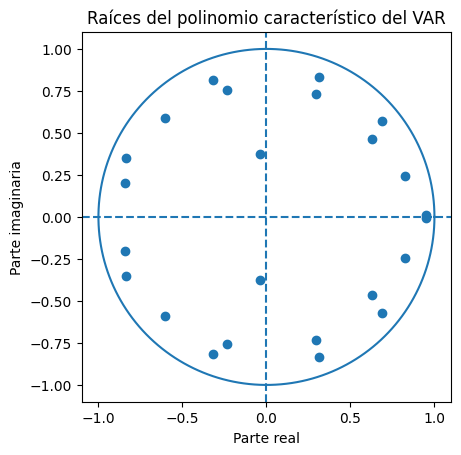

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# —————— RAÍCES DIRECTAS ——————
inv_roots = var_results.roots      # raíces inversas μ = λ⁻¹
roots     = 1.0 / inv_roots       # raíces directas λ = 1/μ
moduli    = np.abs(roots)         # módulos

# —————— GRÁFICO ——————
fig, ax = plt.subplots()
# dibujar círculo unitario
theta = np.linspace(0, 2 * np.pi, 200)
ax.plot(np.cos(theta), np.sin(theta))

# graficar raíces
ax.scatter(roots.real, roots.imag)

# agregar líneas punteadas en x=0 e y=0
ax.axhline(0, linestyle='--')
ax.axvline(0, linestyle='--')

ax.set_aspect('equal', 'box')
ax.set_xlabel('Parte real')
ax.set_ylabel('Parte imaginaria')
ax.set_title('Raíces del polinomio característico del VAR')
plt.show()

In [8]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from scipy.stats import chi2

def select_var_eviews_exact(data, maxlags=8, trend='c'):
    """
    Reproduce la tabla VAR de EViews con:
      • criterios ajustados (AIC, SC, HQ, FPE) marcando el mínimo global
      • LR* secuencial modificado marcando el primer rechazo H₀ (5%)
    """
    k      = data.shape[1]
    T_orig = data.shape[0]
    T_max  = T_orig - maxlags
    const  = k * (1 + np.log(2*np.pi))
    crit_lr = chi2.ppf(0.95, k**2)

    # 1) Estimaciones y captura de llf, fpe, aic0, bic0, hq0, SSR
    llf, fpe, aic0, bic0, hq0, SSR = {}, {}, {}, {}, {}, {}
    for p in range(maxlags+1):
        data_p = data.iloc[maxlags-p:]
        res    = VAR(data_p).fit(p, trend=trend)
        llf[p]    = res.llf
        fpe[p]    = res.fpe
        aic0[p]   = res.aic
        bic0[p]   = res.bic
        hq0[p]    = res.hqic
        SSR[p]    = res.resid.T.dot(res.resid)

    # 2) Construcción de la tabla sin marcas
    rows = []
    for p in range(maxlags+1):
        # criterios ajustados
        AIC = aic0[p] + const
        SC  = bic0[p] + const
        HQ  = hq0[p]  + const

        # LR* secuencial modificado
        if p == 0:
            LR = np.nan
        else:
            _, ld0 = np.linalg.slogdet(SSR[p-1] / T_max)
            _, ld1 = np.linalg.slogdet(SSR[p]   / T_max)
            m       = 1 + k*p
            LR      = (T_max - m) * (ld0 - ld1)

        rows.append({
            'Lag':  p,
            'Nobs': T_max,
            'LogL': llf[p],
            'LR':   LR,
            'FPE':  fpe[p],
            'AIC':  AIC,
            'SC':   SC,
            'HQ':   HQ
        })

    df = pd.DataFrame(rows)

    # 0) Convertimos a object las columnas que vamos a stringificar
    for col in ['LR','FPE','AIC','SC','HQ']:
        df[col] = df[col].astype(object)

    # 3) Marcar mínimos globales para FPE, AIC, SC, HQ
    for crit in ['FPE','AIC','SC','HQ']:
        idx = df[crit].idxmin()
        df.loc[idx, crit] = f"{df.loc[idx,crit]:.6f}*"

    # 4) Marcar primer rechazo H₀ en LR* (descendiendo desde p=maxlags)
    #    según chi2(0.95, k^2)
    for p in range(maxlags, 0, -1):
        val = df.loc[df['Lag']==p, 'LR']
        # si aún es numérico y supera el crítico, marcamos y rompemos
        if isinstance(val.values[0], float) and val.values[0] > crit_lr:
            df.loc[df['Lag']==p, 'LR'] = f"{val.values[0]:.6f}*"
            break

    # 5) Formatear las columnas numéricas a 6 decimales
    for col in ['LogL','LR','FPE','AIC','SC','HQ']:
        df[col] = df[col].apply(lambda x: f"{x:.6f}" if isinstance(x, float) else x)

    return df[['Lag','Nobs','LogL','LR','FPE','AIC','SC','HQ']]

# Ejemplo de uso:
tabla = select_var_eviews_exact(df_f[['dlgp', 'u']], maxlags=16, trend='c')
print(tabla.to_string(index=False))

 Lag  Nobs        LogL         LR       FPE         AIC          SC          HQ
   0   223 1345.603741        nan  0.000000  -12.050258  -12.019700  -12.037922
   1   223 1719.771789 738.268795  0.000000  -15.370151  -15.278478  -15.333143
   2   223 1763.048804  84.613357  0.000000  -15.722411 -15.569623*  -15.660731
   3   223 1773.686991  20.608506  0.000000  -15.781946  -15.568043  -15.695595
   4   223 1779.120795  10.429004  0.000000  -15.794805  -15.519787  -15.683782
   5   223 1789.201672  19.167227  0.000000  -15.849342  -15.513209  -15.713647
   6   223 1797.466453  15.565956  0.000000  -15.887592  -15.490343 -15.727225*
   7   223 1798.123903   1.226453  0.000000  -15.857613  -15.399250  -15.672575
   8   223 1802.556033   8.188510  0.000000  -15.861489  -15.342010  -15.651779
   9   223 1815.701158  24.050273  0.000000  -15.943508  -15.362914  -15.709126
  10   223 1820.527579   8.743830  0.000000  -15.950920  -15.309211  -15.691866
  11   223 1822.333378   3.239102  0.000

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packag

In [9]:
# 1:07:20. Si el ejercicio se dirige hacia cuestiones estructurales, quedarse con LR. Para forecasting o somo bayesianos, vamos con AIC o SC.

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import chi2
from statsmodels.tsa.api import VAR

res = var_results
# extraer nombres y matrices
params    = res.params        # DataFrame con índice ['const','L1.fed_funds',...]
cov_param = res.cov_params()  # DataFrame con índices MultiIndex (param, ecuación)
endogs = df_f[['dlgp', 'u']].columns.tolist()
nlags  = res.k_ar

# --- 3) Función auxiliar para el Wald test univariante -----------------------
def wald_stat(b, Vb):
    W = float(b.T @ np.linalg.inv(Vb) @ b)
    p = 1 - chi2.cdf(W, df=len(b))
    return W, p

# --- 4) Construir tabla de resultados ---------------------------------------
rows = []
for j in range(1, nlags+1):
    # 1) Nombres de coeficientes del lag j en tu formato
    lag_names = [f"L{j}.{var}" for var in endogs]

    row = {"Lag": j}
    joint_idx = []

    for eq in endogs:
        # 2) Vector de coeficientes de la ecuación eq y rezago j
        b = params.loc[lag_names, eq].values

        # 3) Índice para extraer la submatriz de covarianzas:
        #    lista de tuplas (param_name, eq_name)
        idx = list(zip(lag_names, [eq]*len(lag_names)))
        Vb  = cov_param.loc[idx, idx].values

        W, p = wald_stat(b, Vb)
        row[eq]       = round(W, 4)
        row[f"{eq}_p"] = round(p, 4)

        joint_idx += idx

    # 4) Test conjunto (todos los coef. de ese lag)
    # Construimos b_joint en ESE exacto orden:
    b_joint = np.array([
        params.loc[param, eq]
        for (param, eq) in joint_idx
    ])

    # Extraemos la submatriz de varianza–covarianzas en el MISMO orden:
    Vb_joint = cov_param.loc[joint_idx, joint_idx].values

    # Ahora el W y el p salen correctamente:
    Wj, pj = wald_stat(b_joint, Vb_joint)
    row["Joint"]   = round(Wj, 4)
    row["Joint_p"] = round(pj, 4)

    rows.append(row)

# 5) Montamos el DataFrame final con el mismo formato de columnas que EViews
df_wald = (
    pd.DataFrame(rows)
      .set_index("Lag")
      .loc[:, [
          "u", "u_p",
          "dlgp",  "dlgp_p",
          "Joint",      "Joint_p"
      ]]
)

df_wald

,u,u_p,dlgp,dlgp_p,Joint,Joint_p
Lag,,,,,,
1,562.8596,0.0000,16.9986,0.0002,595.4981,0.0000
2,10.6231,0.0049,4.9717,0.0833,12.8011,0.0123
3,5.7110,0.0575,0.3016,0.8600,7.0391,0.1338
4,0.3459,0.8412,1.4024,0.4960,1.6812,0.7941
5,13.6684,0.0011,1.4969,0.4731,13.7368,0.0082
6,5.5117,0.0636,0.4766,0.7880,6.7875,0.1476
7,0.9397,0.6251,4.9308,0.0850,5.7916,0.2153
8,4.3348,0.1145,3.9250,0.1405,11.0123,0.0264
9,20.6438,0.0000,2.8146,0.2448,28.5944,0.0000


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



Response of U:
 Period           u         dlgp
  1     0.002276    0.000000
       ( 0.00011)  ( 0.00000)
  2     0.003418   -0.001192
       ( 0.00024)  ( 0.00017)
  3     0.004215   -0.002325
       ( 0.00038)  ( 0.00032)
  4     0.004096   -0.002985
       ( 0.00051)  ( 0.00047)
  5     0.003474   -0.003263
       ( 0.00060)  ( 0.00058)
  6     0.002961   -0.002729
       ( 0.00065)  ( 0.00064)
  7     0.002561   -0.001893
       ( 0.00067)  ( 0.00066)
  8     0.002626   -0.001484
       ( 0.00068)  ( 0.00067)
  9     0.002112   -0.001253
       ( 0.00068)  ( 0.00067)
 10     0.001831   -0.000629
       ( 0.00066)  ( 0.00068)

Response of DLGP:
 Period           u         dlgp
  1    -0.002267    0.008111
       ( 0.00055)  ( 0.00038)
  2    -0.000449    0.002362
       ( 0.00059)  ( 0.00060)
  3     0.000719    0.001801
       ( 0.00059)  ( 0.00061)
  4     0.001541    0.000555
       ( 0.00059)  ( 0.00061)
  5     0.001500    0.000206
       ( 0.00059)  ( 0.00058)
  6     0.0007

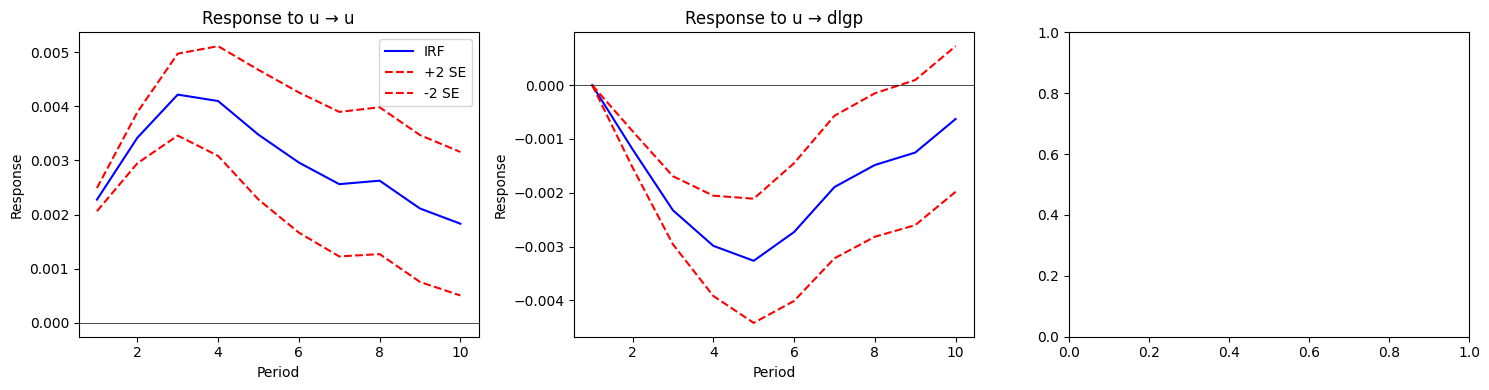

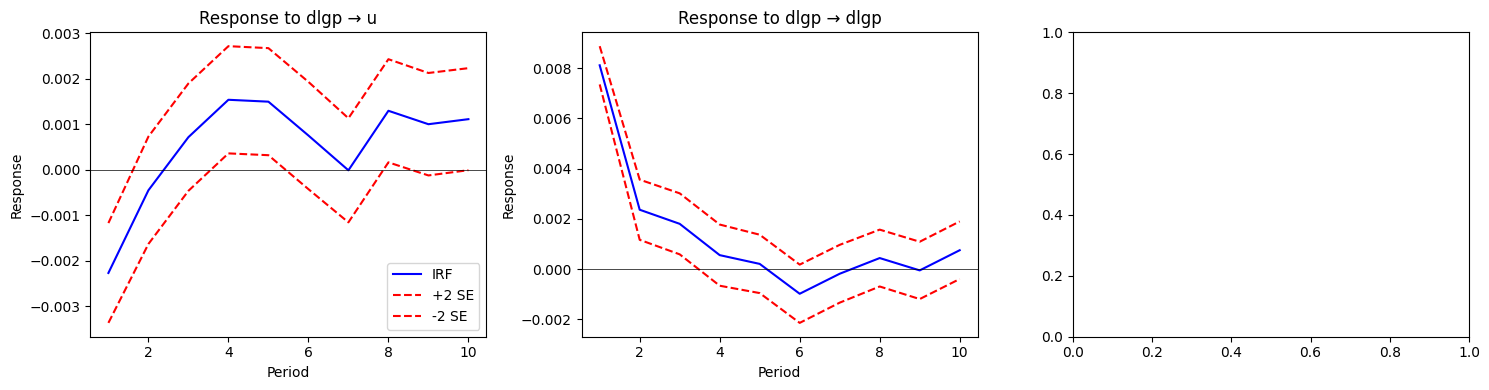

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# 1) Reordena el DataFrame en el orden Cholesky:
data_ord = df_f[['u', 'dlgp']].copy()

# 2) Ajusta el VAR(4):
model_ord = VAR(data_ord)
res_ord   = model_ord.fit(12)

# 3) Calcula las IRFs ortogonalizadas para 10 períodos:
irf       = res_ord.irf(10)
ort_irfs  = irf.orth_irfs      # shape (11,3,3): horizontes 0..10
stderr    = irf.stderr(orth=True)

order     = data_ord.columns.tolist()  # ['fed_funds','inflation','un_rate']
horizons  = np.arange(1,11)            # Periods 1..10

# 4) (Opcional) Imprime también las tablas si quieres:
for resp_var in order:
    i = order.index(resp_var)
    print(f"\nResponse of {resp_var.upper()}:")
    print(" Period  " + "   ".join(f"{v:>10s}" for v in order))
    for h in range(10):
        period_label = h + 1
        vals = "  ".join(f"{ort_irfs[h, i, j]:10.6f}" 
                         for j in range(len(order)))
        ses  = "  ".join(f"({stderr[h, i, j]:8.5f})" 
                         for j in range(len(order)))
        print(f" {period_label:>2d}   {vals}")
        print(f"       {ses}")

# 5) Genera “Multiple Graphs” (3 subplots por fila)
for resp_var in order:
    i   = order.index(resp_var)
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for j, shock in enumerate(order):
        # tomamos h=0..9 como periods 1..10
        y     = ort_irfs[horizons-1, i, j]
        se    = stderr[horizons-1, i, j]
        upper = y + 2 * se
        lower = y - 2 * se

        ax = axs[j]
        ax.plot(horizons, y,    color='blue', label='IRF')
        ax.plot(horizons, upper, color='red',  linestyle='--', label='+2 SE')
        ax.plot(horizons, lower, color='red',  linestyle='--', label='-2 SE')
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_title(f'Response to {resp_var} → {shock}')
        ax.set_xlabel('Period')
        ax.set_ylabel('Response')
        if j == 0:
            ax.legend()

    plt.tight_layout()
    plt.show()

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



Response of DLGP:
 Period        dlgp            u
  1     0.008422    0.000000
       ( 0.00040)  ( 0.00000)
  2     0.002396    0.000203
       ( 0.00059)  ( 0.00058)
  3     0.001541    0.001177
       ( 0.00061)  ( 0.00058)
  4     0.000120    0.001634
       ( 0.00062)  ( 0.00059)
  5    -0.000205    0.001500
       ( 0.00060)  ( 0.00058)
  6    -0.001149    0.000463
       ( 0.00059)  ( 0.00057)
  7    -0.000176   -0.000059
       ( 0.00058)  ( 0.00057)
  8     0.000073    0.001370
       ( 0.00058)  ( 0.00056)
  9    -0.000321    0.000953
       ( 0.00058)  ( 0.00056)
 10     0.000423    0.001276
       ( 0.00058)  ( 0.00055)

Response of U:
 Period        dlgp            u
  1    -0.000613    0.002192
       ( 0.00015)  ( 0.00010)
  2    -0.002068    0.002971
       ( 0.00027)  ( 0.00021)
  3    -0.003374    0.003433
       ( 0.00040)  ( 0.00033)
  4    -0.003978    0.003141
       ( 0.00052)  ( 0.00045)
  5    -0.004078    0.002468
       ( 0.00061)  ( 0.00055)
  6    -0.0034

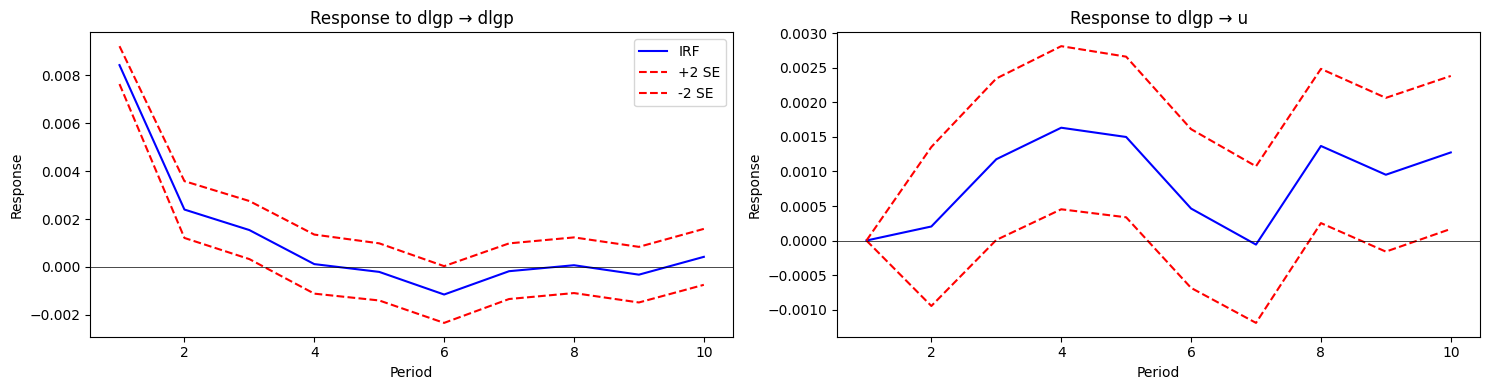

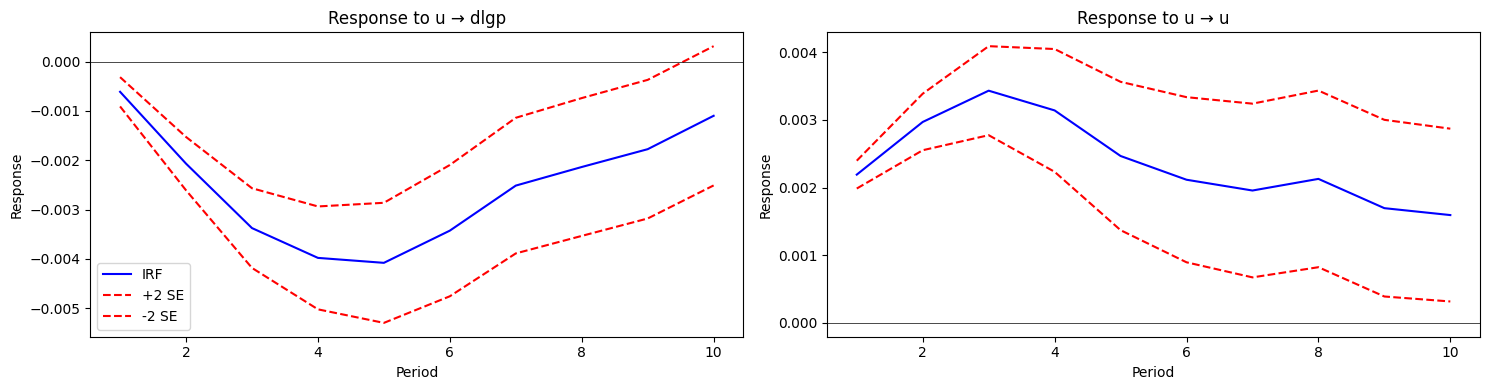

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# 1) Reordena el DataFrame en el orden Cholesky:
data_ord = df_f[['dlgp', 'u']].copy()

# 2) Ajusta el VAR(4):
model_ord = VAR(data_ord)
res_ord   = model_ord.fit(12)

# 3) Calcula las IRFs ortogonalizadas para 10 períodos:
irf       = res_ord.irf(10)
ort_irfs  = irf.orth_irfs      # shape (11,3,3): horizontes 0..10
stderr    = irf.stderr(orth=True)

order     = data_ord.columns.tolist()  # ['fed_funds','inflation','un_rate']
horizons  = np.arange(1,11)            # Periods 1..10

# 4) (Opcional) Imprime también las tablas si quieres:
for resp_var in order:
    i = order.index(resp_var)
    print(f"\nResponse of {resp_var.upper()}:")
    print(" Period  " + "   ".join(f"{v:>10s}" for v in order))
    for h in range(10):
        period_label = h + 1
        vals = "  ".join(f"{ort_irfs[h, i, j]:10.6f}" 
                         for j in range(len(order)))
        ses  = "  ".join(f"({stderr[h, i, j]:8.5f})" 
                         for j in range(len(order)))
        print(f" {period_label:>2d}   {vals}")
        print(f"       {ses}")

# 5) Genera “Multiple Graphs” (3 subplots por fila)
for resp_var in order:
    i   = order.index(resp_var)
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for j, shock in enumerate(order):
        # tomamos h=0..9 como periods 1..10
        y     = ort_irfs[horizons-1, i, j]
        se    = stderr[horizons-1, i, j]
        upper = y + 2 * se
        lower = y - 2 * se

        ax = axs[j]
        ax.plot(horizons, y,    color='blue', label='IRF')
        ax.plot(horizons, upper, color='red',  linestyle='--', label='+2 SE')
        ax.plot(horizons, lower, color='red',  linestyle='--', label='-2 SE')
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_title(f'Response to {resp_var} → {shock}')
        ax.set_xlabel('Period')
        ax.set_ylabel('Response')
        if j == 0:
            ax.legend()

    plt.tight_layout()
    plt.show()

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



Variance Decomposition of DLGP:
 Period     S.E.         DLGP            U
  1     0.008422   100.000000    0.000000
  2     0.008758    99.946081    0.053919
  3     0.008970    98.225554    1.774446
  4     0.009119    95.071939    4.928061
  5     0.009244    92.570948    7.429052
  6     0.009326    92.455073    7.544927
  7     0.009328    92.454079    7.545921
  8     0.009428    90.503455    9.496545
  9     0.009482    89.600106   10.399894
 10     0.009577    88.029755   11.970245

Variance Decomposition of U:
 Period     S.E.         DLGP            U
  1     0.002276     7.248138   92.751862
  2     0.004276    25.450404   74.549596
  3     0.006439    38.685098   61.314902
  4     0.008194    47.448663   52.551337
  5     0.009480    53.959218   46.040782
  6     0.010300    56.773735   43.226265
  7     0.010781    57.251809   42.748191
  8     0.011195    56.737851   43.262149
  9     0.011461    56.533311   43.466689
 10     0.011623    55.858693   44.141307


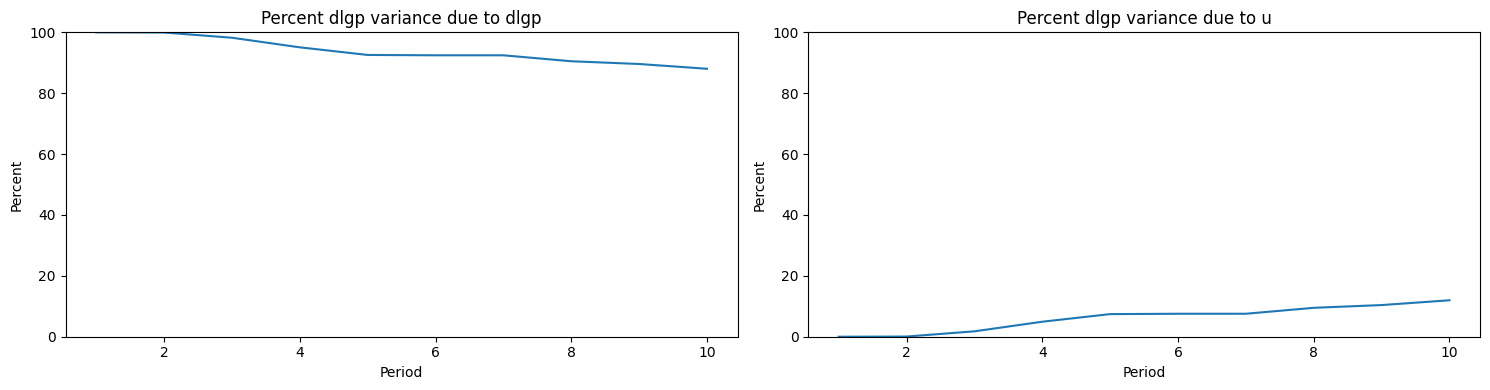

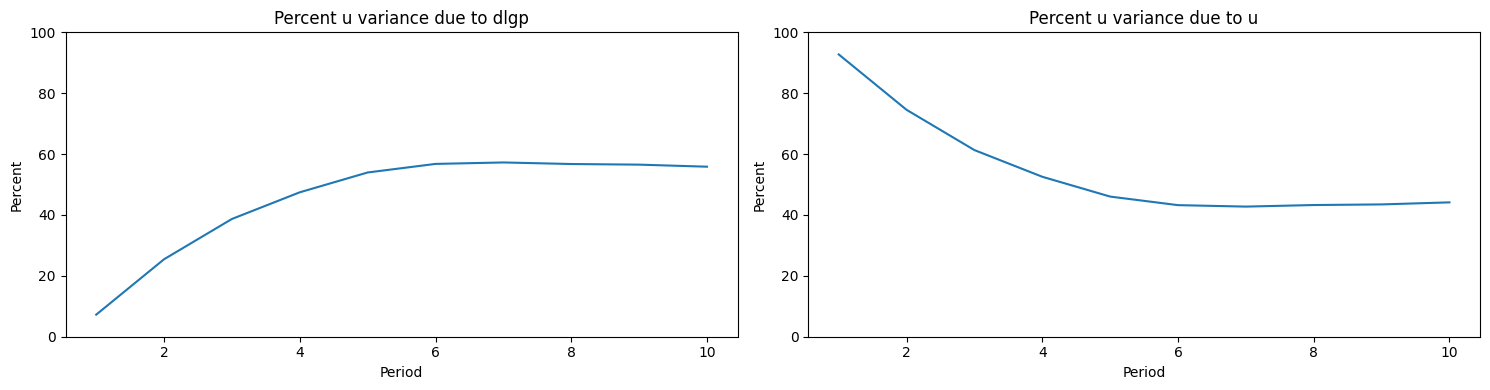

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# ——— 1) Reordena y ajusta el VAR(4) ——————————————————————————————————
data_ord = df_f[['dlgp', 'u']].copy() #Cholesky ordering.
res_ord  = VAR(data_ord).fit(12)

# ——— 2) FEVD para 10 periodos ortogonalizada (Cholesky) —————————————————
fevd   = res_ord.fevd(10)
decomp = fevd.decomp       # shape (3, 10, 3): (var, horizons 1..10, shock)

# Matriz de var–cov de errores de pronóstico y sus S.E.
mse = res_ord.mse(10)      # shape (10,3,3)
se  = np.sqrt(np.diagonal(mse, axis1=1, axis2=2))  # shape (10,3)

order    = data_ord.columns.tolist()  # ['fed_funds','inflation','un_rate']
horizons = np.arange(1, 11)          # Periods 1..10

# ——— 3) Imprime la tabla estilo EViews ————————————————————————————————
for i, var in enumerate(order):
    print(f"\nVariance Decomposition of {var.upper()}:")
    header = " Period     S.E.   " + "   ".join(f"{v.upper():>10s}" for v in order)
    print(header)
    for h in range(10):
        pct   = decomp[i, h, :] * 100  # fracción→%
        seval = se[h, i]
        vals  = "  ".join(f"{p:10.6f}" for p in pct)
        print(f" {h+1:>2d}   {seval:10.6f}   {vals}")

# ——— 4) Genera “Multiple Graphs” de % de varianza (3 por fila) —————————
for i, var in enumerate(order):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for j, shock in enumerate(order):
        pct = decomp[i, :, j] * 100  # 10 valores → periods 1..10
        ax  = axs[j]
        ax.plot(horizons, pct)
        ax.set_title(f'Percent {var} variance due to {shock}')
        ax.set_xlabel('Period')
        ax.set_ylabel('Percent')
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [ ]:
# Puede estimarse la ecuación de la forma reducida (contemplando que los errores están correlacionados, por lo que se deberán ortogonalizar los mismos)
#  o la ecuación estructural (con errores no correlacionados) incorporando una restricción correspondiente (debe estar teóricamente fundamentada). 
# 

In [25]:
from statsmodels.tsa.api import VAR

# Crear el modelo VAR.
model = VAR(df_f[['dlgp', 'u']])
var_results = model.fit(maxlags=12)
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 03, May, 2025
Time:                     23:50:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -20.8381
Nobs:                     227.000    HQIC:                  -21.2881
Log likelihood:           1856.55    FPE:                4.20034e-10
AIC:                     -21.5925    Det(Omega_mle):     3.40828e-10
--------------------------------------------------------------------
Results for equation dlgp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.000139         0.002913           -0.048           0.962
L1.dlgp          0.291275         0.072529            4.016           0.000
L1.u             0.092772         0.262630            0.353           0.724
L2.dl

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.linalg import cholesky
from scipy.stats import norm
from statsmodels.tsa.api import VAR

# —————————————————————————————
# Aseguramos que el índice sea datetime
df_f.index = pd.to_datetime(df_f.index)

# 1) Estimar el VAR(12) reducido
model = VAR(df_f[['dlgp','u']])
res   = model.fit(maxlags=12)

# 2) Long‐run effects y Cholesky
Psi_inf = res.long_run_effects()
Sigma_u = res.sigma_u
P       = cholesky(Sigma_u, lower=True)

# 3) Rotación para @LR1(@U1)=0
J   = Psi_inf @ P
θ   = np.arctan2(-J[0,0], J[0,1])
Q   = np.array([[np.cos(θ), -np.sin(θ)],
                [np.sin(θ),  np.cos(θ)]])
# 4) Structural impact matrix (“S matrix” de EViews)
S_struct  = P @ Q
# 5) Long‑run impact (“F matrix” de EViews)
F_struct  = Psi_inf @ S_struct

# 6) Coeficientes C(1)–C(3) de F_struct
coeffs = np.array([F_struct[1,0], F_struct[0,1], F_struct[1,1]])

# 7) Bootstrap paramétrico (300 réplicas) para errores estándar
B      = 300
boot   = np.zeros((B, 3))
T_full = len(res.endog)
for i in range(B):
    Yb = res.simulate_var(steps=T_full)
    rb = VAR(Yb).fit(maxlags=12)
    Pb = cholesky(rb.sigma_u, lower=True)
    Ji = rb.long_run_effects() @ Pb
    θi = np.arctan2(-Ji[0,0], Ji[0,1])
    Qi = np.array([[np.cos(θi), -np.sin(θi)],
                   [np.sin(θi),  np.cos(θi)]])
    LRbi = rb.long_run_effects() @ (Pb @ Qi)
    boot[i,:] = [LRbi[1,0], LRbi[0,1], LRbi[1,1]]

std_errs = boot.std(axis=0, ddof=1)
z_stats  = coeffs / std_errs
p_vals   = 2 * (1 - norm.cdf(np.abs(z_stats)))

# 8) Fechas de muestra ajustada
start_q = pd.Period(df_f.index[res.k_ar], freq='Q')
end_q   = pd.Period(df_f.index[-1],     freq='Q')
nobs    = res.nobs

# 9) Impresión “EViews‐style”
now      = datetime.now()
date_str = now.strftime("%m/%d/%y")
time_str = now.strftime("%H:%M")

print("Structural VAR Estimates")
print(f"Date: {date_str}   Time: {time_str}")
print(f"Sample (adjusted): {start_q} {end_q}")
print(f"Included observations: {nobs} after adjustments")
print("Estimation method: OLS (Gaussian likelihood)")
print("Convergence achieved after 1 iteration")
print("Structural VAR is just-identified\n")
print("Model: e = Phi*F u where E[uu']=I\n")

print("Estimated S matrix:")   # Ésta es la F que EViews llama “S matrix”
for row in S_struct:
    print(" ".join(f"{x:>10.6f}" for x in row))

print("\nEstimated F matrix:")   # Ésta es la F de EViews
for row in F_struct:
    print(" ".join(f"{x:>10.6f}" for x in row))

print("\nincluding the restriction(s)")
print("@LR1(@U1)=0\n")
print("\tCoefficient\tStd. Error\tz-Statistic\tProb.")
for i, (c, se, z, p) in enumerate(zip(coeffs, std_errs, z_stats, p_vals), start=1):
    print(f"C({i})\t{c:>10.6f}\t{se:>10.6f}\t{z:>11.5f}\t{p:>9.4f}")

print(f"\nLog likelihood\t {res.llf:>10.3f}")

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


Structural VAR Estimates
Date: 05/04/25   Time: 00:26
Sample (adjusted): 1970Q1 1970Q1
Included observations: 227 after adjustments
Estimation method: OLS (Gaussian likelihood)
Convergence achieved after 1 iteration
Structural VAR is just-identified

Model: e = Phi*F u where E[uu']=I

Estimated S matrix:
  0.005300   0.006545
 -0.002089   0.000903

Estimated F matrix:
  0.000000   0.037998
 -0.048330   0.070049

including the restriction(s)
@LR1(@U1)=0

	Coefficient	Std. Error	z-Statistic	Prob.
C(1)	 -0.048330	  0.011018	   -4.38630	   0.0000
C(2)	  0.037998	  0.014576	    2.60682	   0.0091
C(3)	  0.070049	  0.037426	    1.87169	   0.0612

Log likelihood	   1856.548


In [ ]:
#min 1:25.